# Assignment #01

This assignment is composed of 4 tasks that your teams is supposed to propose a solution to these tasks that uses  the max-tree. The deliverable for this assignment is:

1. This jupyter-notebook completed with your solution. 
    - Create a GitHub repository and create a folder assignment-01. Put the jupyter-notebook with your solution in this repository and send the instructor the link. The same repository that your team created will be used for submitting the other assignments and your team final project.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 40% 
4. Quality of the results - 20%

More details about the assessment are available in the rubric document in the class GitHub repository.

In [134]:
! git clone https://github.com/rmsouza01/ENSF619.2.git
! git clone https://github.com/rmsouza01/siamxt.git; cd siamxt; python setup.py install

fatal: destination path 'ENSF619.2' already exists and is not an empty directory.
fatal: destination path 'siamxt' already exists and is not an empty directory.
running install
running build
running build_py
running build_ext
running install_lib
running install_egg_info
Removing /usr/local/lib/python3.7/dist-packages/siamxt-1.0.0.egg-info
Writing /usr/local/lib/python3.7/dist-packages/siamxt-1.0.0.egg-info


In [135]:
import numpy as np # numpy is the major library in which siamxt was built upon
                   # we like the array programming style =)

# We are using PIL to read images     
from PIL import Image

# and matplotlib to display images
import matplotlib.pyplot as plt

import siamxt  
import nibabel as nib

In [136]:
# helper functions to display image and graphs.

def showImage(img, title):
  #Displaying the image
  plt.imshow(img, cmap='Greys_r')
  plt.axis('off')
  plt.title(title)

def printNode(mxt, area, plotNum):
  node = np.where(mxt.node_array[3,:] == area)[0][0]
  cc = mxt.recConnectedComponent(node)

  plt.subplot(plotNum)
  showImage(cc, "Reconstruction at h = %d" %mxt.node_array[2,node])
  
def displaySignatureGraphs(levels, signature, gradient):
  # Display area signature
  fig = plt.figure(figsize = (10,5))
  plt.subplot(121)
  plt.plot(levels,signature)
  plt.xlabel("Gray-level")
  plt.ylabel("Area")
  plt.title("Area signature")


  # Display gradient of the area signature
  plt.subplot(122)
  plt.grid()
  plt.plot(levels[0:-1],gradient)
  plt.xlabel("Gray-level")
  plt.ylabel("Gradient")
  plt.title("Gradient signature")


**Part 1)** Using the max tree area signature analysis, determined CCs in the max tree
that separate Mona Lisa’s face from the background

(317, 213)


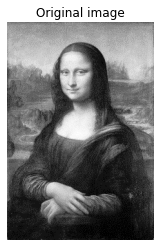

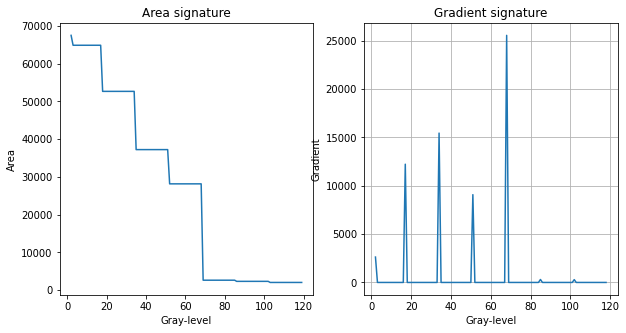

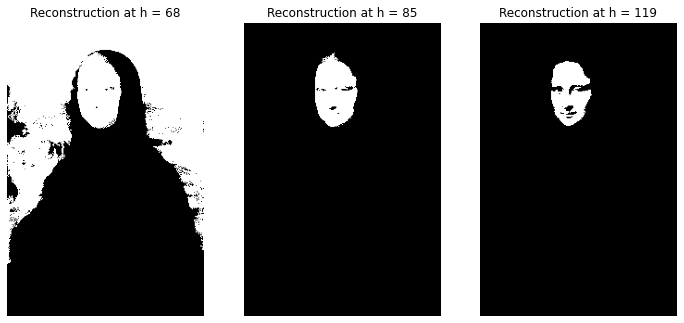

In [137]:
# Loading the image.
# Make sure the image you read is either uint8 or uint16
img = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/monalisa.png").convert("L"))
print(img.shape)


# Solution provided by Minaoar, UCID 30154080
showImage(img, "Original image")

#Structuring element with connectivity-8
Bc = np.ones((3,3),dtype = bool)

# Building the max-tree
mxt = siamxt.MaxTreeAlpha(img,Bc)


#Hand-picked regional maxima by targeting the face of Monalisa
x,y = 74,100

# Node corresponding to a regional maximum
node = mxt.node_index[x,y]

# Extracting area attribute from node array
area = mxt.node_array[3,:]

# Area signature computation
levels,signature =  mxt.getSignature(area, node)

#Gradient of the area signature
gradient = signature[0:-1] - signature[1:]

#Display signature and gradient graphs
displaySignatureGraphs(levels, signature, gradient)

# Sorting the gradient values
sorted_grad = np.argsort(gradient)[::-1]

# Selecting the highest peak of the gradient
index = sorted_grad[0]

  
#reconstructing the node corresponding to the peak (largest area)
area1 = signature[index]

#reconstructing the node corresponding to the next peak (smaller area)
area2 = signature[index1+1]

#reconstructing the last peak, as it kept the nose and lips edges.
area3 = signature[-1]


#Displaying the nodes reconstructed    
fig = plt.figure(figsize = (12,6))
printNode(mxt, area1, 131)
printNode(mxt, area2, 132)
printNode(mxt, area3, 133)

plt.grid()


**Part 2)** Apply a series of filters to this image to segment the carotid arteries wall

(322, 322)


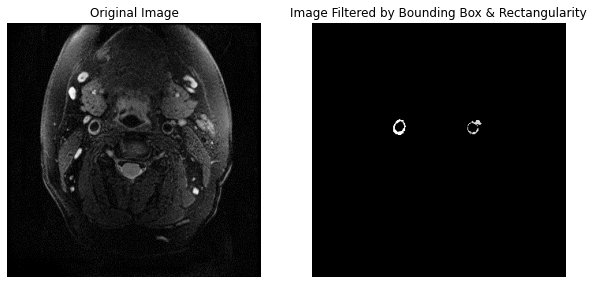

In [138]:
# Loading the image.
img = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/carotid.png").convert("L"))
print(img.shape)

# Solution by Minaoar, UCID 30154080

# Filter parameters are identified by manual trial and errors.
Wmin = 10  # Minimum bounding-box width
Hmin = 6 # Minimum bounding-box height
Wmax = 18 # Maximum bounding-box width
Hmax = 20 # Maximum bounding-box height
rr_min = 0.30 # Minimum rectangularity ratio - to include circular component
rr_max = 0.38 # Maximum rectangularity ratio - to exclude filled-in components, as our target image is a ring structure.
target_artery_xmax = 150 #maximum x-coordinate of arteries
target_artery_xmin = 100 #minimum x-coordinate of arteries

#Structuring element with connectivity-8 
Bc = np.ones((3,3), dtype = bool)

# Building the max-tree
mxt = siamxt.MaxTreeAlpha(img,Bc)

# Bounding box-lengths
dx = mxt.node_array[7,:] - mxt.node_array[6,:]
dy = mxt.node_array[10,:] - mxt.node_array[9,:]

# Rectangularity ratio
RR = mxt.computeRR()

# Node selection criteria
nodes = (dx>Hmin) & (dx<Hmax) & (dy > Wmin) & (dy < Wmax) & (mxt.node_array[6,:] > target_artery_xmin) & (mxt.node_array[6,:] < target_artery_xmax) & (RR > rr_min) & (RR < rr_max)                       
      
#Filtering the max-tree
mxt.contractDR(nodes)

# Recovering the filtered the image
img_filtered = mxt.getImage()

#Displaying the original and filtered images 
fig = plt.figure(figsize = (10,5))

plt.subplot(121)
showImage(img, "Original Image")

plt.subplot(122)
showImage(img_filtered, "Image Filtered by Bounding Box & Rectangularity") 


**Parte 3)** Apply a series of filters to remove the white artifacts in the image

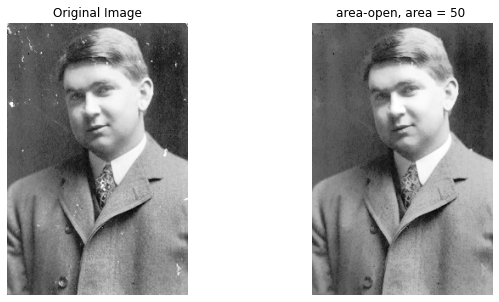

In [139]:
# Loading the image.
img = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/filtering-image.jpg").convert("L"))

# Solution by Minaoar, UCID 30154080
# Area threshold
areaThreshold = 50

#Building the max-tree of the image
Bc = np.ones((3,3),dtype = bool)

mxt = siamxt.MaxTreeAlpha(img,Bc)

#Applying an area-open filter
mxt.areaOpen(areaThreshold)

img_filtered = mxt.getImage()

#Displaying the original and filtered images 
fig = plt.figure(figsize = (10,5))

plt.subplot(121)
showImage(img, "Original Image")

plt.subplot(122)
showImage(img_filtered, "area-open, area = %d " %areaThreshold) 


**Part 4)** Apply a series of filters that will remove all objects in the image except for the
two pens

(381, 384)


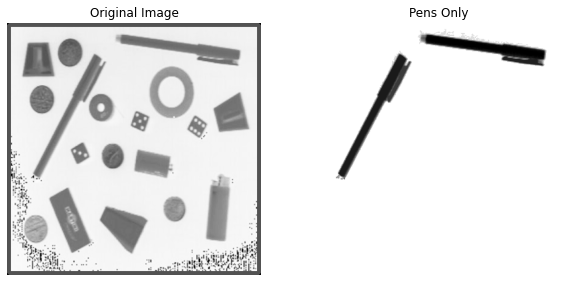

In [140]:
# Loading the image.
img = np.asarray(Image.open("/content/ENSF619.2/Assignment01/Images/objects.png").convert("L"))
print(img.shape)

# Solution by Minaoar, UCID 30154080

# Filter parameters
Wmin = 70  # Minimum bounding-box width
Hmin = 20 # Minimum bounding-box height
Wmax = 200 # Maximum bounding-box width
Hmax = 200 # Maximum bounding-box height
rr = 0.1 # Minimum rectangularity ratio
rr_max = 0.4 # Minimum rectangularity ratio

#Structuring element with connectivity-4 
Bc = np.zeros((3,3), dtype = bool)
Bc[1,:] = True
Bc[:,1] = True

# Getting the negative of the image to apply filter on the black components
img_neg = img.max() - img

# Building the max-tree of the image
mxt = siamxt.MaxTreeAlpha(img_neg,Bc)

# Bounding box-lengths
dx = mxt.node_array[7,:] - mxt.node_array[6,:]
dy = mxt.node_array[10,:] - mxt.node_array[9,:]

# Rectangularity ratio
RR = mxt.computeRR()

# Node selection criteria
nodes = (dx>Hmin) & (dx<Hmax) & (dy > Wmin) & (dy < Wmax) & (RR > rr) & (RR < rr_max)

#Filtering the max-tree
mxt.contractDR(nodes)

# Recovering the filtered the image
img_filtered = mxt.getImage()

# Getting the negative of the filtered image
img_filtered = img_filtered.max() - img_filtered
 
fig = plt.figure(figsize = (10,5))
plt.subplot(121)
showImage(img, "Original Image")

plt.subplot(122)
showImage(img_filtered, "Pens Only") 